# cell below updates interaction times code

In [3]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

# Function to read FED3 events and extract timestamps for multiple interaction events
def get_FEDevents(filename, eventnames):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = []
    for row in csvreader:
        rows.append(row)

    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    try:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[1])
        date_format = formats[1]

    timestamps = []
    for row in rows:
        if row[7] in eventnames:  # Check for any of the event names (pokes, pellet retrievals, etc.)
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    return timestamps

# Function to calculate the total interaction time based on timestamps
def calculate_interaction_time(timestamps):
    if len(timestamps) < 2:
        return 0  # No interactions if fewer than 2 timestamps

    # Calculate time differences between consecutive events
    interaction_times = [(timestamps[i+1] - timestamps[i]).total_seconds() for i in range(len(timestamps)-1)]

    # Consider interactions that happen within 1 minute as continuous
    threshold_seconds = 60
    total_interaction_time = sum([t for t in interaction_times if t <= threshold_seconds])

    # Return the total interaction time in minutes
    return total_interaction_time / 60

# Processing the metafile data to extract relevant timestamps for each mouse
metafile = "..\\FEDProtein_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[1]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["sex"] = row[4]
        mice[mouse_id]["order"] = row[5]

# Modify this section to include multiple event types for interaction
event_types = ['Pellet', 'LeftPoke', 'RightPoke', 'RightWithPellet',"LeftWithPellet"]  # Add all relevant interaction events

for key in mice.keys():
    for row in rows:
        if row[1] == key and row[3] == "FF":  # Focus on free-feeding mode
            filename = "..\\data\\{}".format(row[0])
            if row[2] == "GRAIN":
                mice[key]["grain_timestamps"] = get_FEDevents(filename, event_types)
            elif row[2] == "PR":
                mice[key]["pr_timestamps"] = get_FEDevents(filename, event_types)
            elif row[2] == "NR":
                mice[key]["nr_timestamps"] = get_FEDevents(filename, event_types)
            else:
                print(row[2], "is not a valid type of pellet for", key)

# Calculate interaction times and store them in the dictionary
for key in mice.keys():
    grain_timestamps = mice[key].get("grain_timestamps", [])
    pr_timestamps = mice[key].get("pr_timestamps", [])
    nr_timestamps = mice[key].get("nr_timestamps", [])

    # Calculate interaction time for each phase
    mice[key]["grain_interaction_time"] = calculate_interaction_time(grain_timestamps)
    mice[key]["pr_interaction_time"] = calculate_interaction_time(pr_timestamps)
    mice[key]["nr_interaction_time"] = calculate_interaction_time(nr_timestamps)

# Function to save interaction times to a CSV
def save_interaction_times_to_csv(mice_data, output_filename):
    with open(output_filename, mode='w', newline='') as file:
        fieldnames = ['mouse_id', 'sex', 'order', 'grain_interaction_time', 'pr_interaction_time', 'nr_interaction_time']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        # Write the header
        writer.writeheader()
        
        # Write interaction time data for each mouse
        for mouse_id, mouse_data in mice_data.items():
            row_data = {
                'mouse_id': mouse_id,
                'sex': mouse_data.get('sex', None),
                'order': mouse_data.get('order', None),
                'grain_interaction_time': mouse_data.get('grain_interaction_time', None),
                'pr_interaction_time': mouse_data.get('pr_interaction_time', None),
                'nr_interaction_time': mouse_data.get('nr_interaction_time', None)
            }
            writer.writerow(row_data)

# Save the interaction times to a CSV file
output_filename = '../results/Interaction_time_stats/mice_interaction_times_Updated.csv'  
save_interaction_times_to_csv(mice, output_filename)


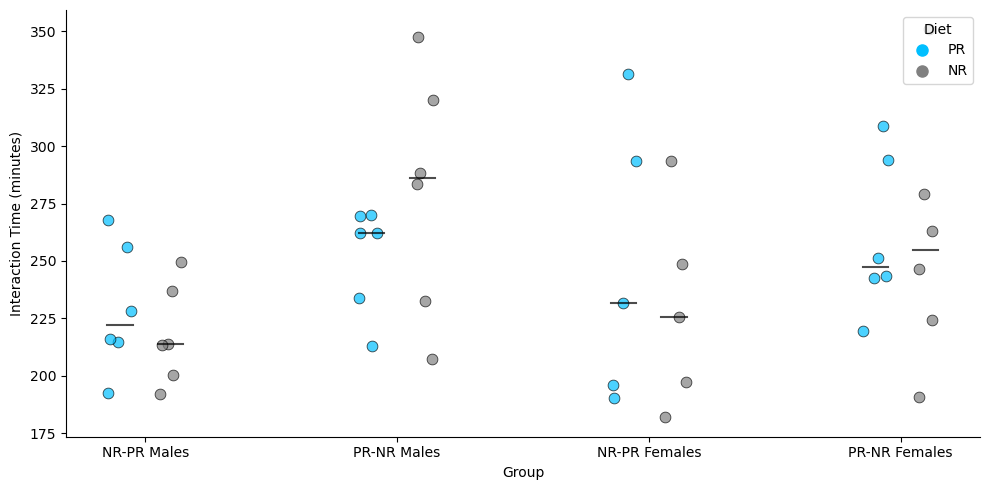

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the interaction times CSV file
interaction_data = pd.read_csv("../results/Interaction_time_stats/mice_interaction_times_Updated.csv")

# Group selectors based on your criteria
nrpr_male_selector = (interaction_data['order'] == 1) & (interaction_data['sex'] == 'M')
prnr_male_selector = (interaction_data['order'] == 2) & (interaction_data['sex'] == 'M')
nrpr_female_selector = (interaction_data['order'] == 1) & (interaction_data['sex'] == 'F')
prnr_female_selector = (interaction_data['order'] == 2) & (interaction_data['sex'] == 'F')

# Extract data for each group and phase, but only for PR and NR
nrpr_male_data = interaction_data[nrpr_male_selector][['pr_interaction_time', 'nr_interaction_time']]
prnr_male_data = interaction_data[prnr_male_selector][['pr_interaction_time', 'nr_interaction_time']]
nrpr_female_data = interaction_data[nrpr_female_selector][['pr_interaction_time', 'nr_interaction_time']]
prnr_female_data = interaction_data[prnr_female_selector][['pr_interaction_time', 'nr_interaction_time']]

# Combine all data for easier plotting
data = [
    nrpr_male_data['pr_interaction_time'], nrpr_male_data['nr_interaction_time'],
    prnr_male_data['pr_interaction_time'], prnr_male_data['nr_interaction_time'],
    nrpr_female_data['pr_interaction_time'], nrpr_female_data['nr_interaction_time'],
    prnr_female_data['pr_interaction_time'], prnr_female_data['nr_interaction_time']
]

group_labels = [
    "NR-PR Males (PR)", "NR-PR Males (NR)",
    "PR-NR Males (PR)", "PR-NR Males (NR)",
    "NR-PR Females (PR)", "NR-PR Females (NR)",
    "PR-NR Females (PR)", "PR-NR Females (NR)"
]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Adjust offsets for PR and NR
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the scatter plot
jitter_strength = 0.05  # Jitter for spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=60, alpha=0.7, edgecolor="black")

# Add median lines
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.05, x_val + 0.05], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend
custom_lines = [
    plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
    plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')
]
plt.legend(handles=custom_lines, title="Diet", loc="upper right")

# Customize the plot aesthetics
plt.xticks(
    [group_positions["NR-PR Males"], group_positions["PR-NR Males"],
     group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
    ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Interaction Time (minutes)")

# Remove grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()


# cell below, finding the dynamics of interaction with FED3

In [9]:
import csv
from datetime import datetime, timedelta
import numpy as np
import trompy as tp

# Function to read FED3 events and extract timestamps for multiple interaction events
def get_FEDevents(filename, eventnames):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = []
    for row in csvreader:
        rows.append(row)

    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    try:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[1])
        date_format = formats[1]

    timestamps = []
    for row in rows:
        if row[7] in eventnames:  # Check for any of the event names (pokes, pellet retrievals, etc.)
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    return timestamps

# Function to calculate interaction time per day using a threshold
def calculate_interaction_time_per_day(timestamps, days=7):
    if len(timestamps) < 2:
        return [0] * days  # No interactions, return zeros for each day

    t0 = timestamps[0].strftime('%Y-%m-%d')  # Reference point at the start of the first day
    lightson = t0 + " 07:00:00"
    refpoint = datetime.strptime(lightson, '%Y-%m-%d %H:%M:%S')
    
    interaction_times = [0] * days
    threshold_seconds = 60  # 1-minute threshold

    # Iterate through the timestamps and accumulate interaction time per day
    for i in range(1, len(timestamps)):
        delta_time = (timestamps[i] - timestamps[i-1]).total_seconds()
        current_day = (timestamps[i-1] - refpoint).days

        if 0 <= current_day < days and delta_time <= threshold_seconds:
            interaction_times[current_day] += delta_time / 60  # Convert to minutes

    return interaction_times

# Processing the metafile data to extract relevant timestamps for each mouse
metafile = "..\\FEDProtein_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[1]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["sex"] = row[4]
        mice[mouse_id]["order"] = row[5]

# Modify this section to include multiple event types for interaction
event_types = ['Pellet', 'LeftPoke', 'RightPoke', 'RightWithPellet', 'LeftWithPellet']

for key in mice.keys():
    for row in rows:
        if row[1] == key and row[3] == "FF":  # Focus on free-feeding mode
            filename = "..\\data\\{}".format(row[0])
            if row[2] == "GRAIN":
                mice[key]["grain_timestamps"] = get_FEDevents(filename, event_types)
            elif row[2] == "PR":
                mice[key]["pr_timestamps"] = get_FEDevents(filename, event_types)
            elif row[2] == "NR":
                mice[key]["nr_timestamps"] = get_FEDevents(filename, event_types)
            else:
                print(row[2], "is not a valid type of pellet for", key)

# Calculate interaction times per day and store them in the dictionary
for key in mice.keys():
    grain_timestamps = mice[key].get("grain_timestamps", [])
    pr_timestamps = mice[key].get("pr_timestamps", [])
    nr_timestamps = mice[key].get("nr_timestamps", [])

    # Calculate interaction time per day for each phase using the threshold
    mice[key]["grain_interaction_time_per_day"] = calculate_interaction_time_per_day(grain_timestamps, days=3)
    mice[key]["pr_interaction_time_per_day"] = calculate_interaction_time_per_day(pr_timestamps, days=7)
    mice[key]["nr_interaction_time_per_day"] = calculate_interaction_time_per_day(nr_timestamps, days=7)

    # Combine all interaction times per day into a single list for 17 days
    mice[key]["all_interaction_times_per_day"] = (
        mice[key].get("grain_interaction_time_per_day", [0] * 3) +
        mice[key].get("pr_interaction_time_per_day", [0] * 7) +
        mice[key].get("nr_interaction_time_per_day", [0] * 7)
    )

# Function to save interaction times to a CSV
def save_interaction_times_to_csv(mice_data, output_filename):
    with open(output_filename, mode='w', newline='') as file:
        fieldnames = ['mouse_id', 'sex', 'order', 'all_interaction_times_per_day']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        # Write the header
        writer.writeheader()
        
        # Write interaction time data for each mouse
        for mouse_id, mouse_data in mice_data.items():
            row_data = {
                'mouse_id': mouse_id,
                'sex': mouse_data.get('sex', None),
                'order': mouse_data.get('order', None),
                'all_interaction_times_per_day': mouse_data.get('all_interaction_times_per_day', None)
            }
            writer.writerow(row_data)

# Save the interaction times to a CSV file
output_filename = '../results/Interaction_time_stats/PER_DAY_DYNAMICS/mice_all_interaction_times_per_day.csv'  
save_interaction_times_to_csv(mice, output_filename)


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


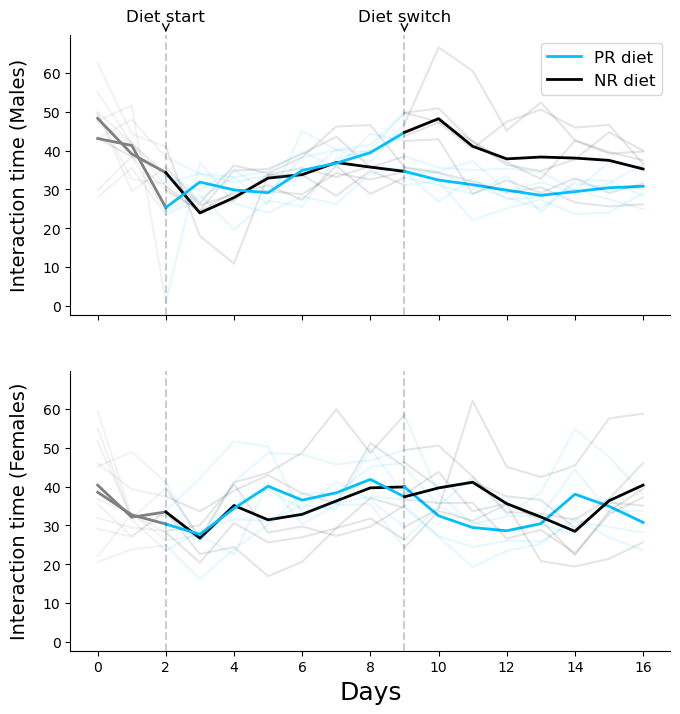

In [13]:
import matplotlib.pyplot as plt
import numpy as np
def get_data_subset(dictionary, selectors, verbose=True):
    output_dictionary = dictionary.copy()
    for key, value in selectors.items():
        for mouse_id in dictionary.keys():
            try:
                if output_dictionary[mouse_id][key] != value:
                    output_dictionary.pop(mouse_id)
            except KeyError: 
                pass

    if verbose:
        print("{} items in output dictionary".format(len(output_dictionary.keys())))
    
    return output_dictionary

def get_data_fields(dictionary, fields, selectors):
    output_list = []
    reduced_dictionary = get_data_subset(dictionary, selectors)
    
    if len(reduced_dictionary.keys()) > 0:
        for field in fields:
            output_sublist = []
            try:
                for key in reduced_dictionary.keys():
                    output_sublist.append(reduced_dictionary[key][field])
            except KeyError:
                print("{} is not a key in selected dictionary".format(field))
                return
            output_list.append(output_sublist)
    else:
        print("No data in fields in selected dictionary")

    if len(output_list) == 1:
        output_list = output_list[0]
        
    return output_list
# Function to plot individual timelines for interaction time
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines for phase change
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    # Initialize lines for legend
    pr_line = None
    nr_line = None

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)  # First phase in color (PR diet)
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)  # Second phase in color (NR diet)

        # Plot the mean values and store lines for the legend
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        pr_line, = ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2, label="PR diet")  # First phase mean
        nr_line, = ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2, label="NR diet")  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=14, labelpad=10)  # Add label padding to avoid overlap
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    # Remove the upper and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    return ax, pr_line, nr_line

# Selectors for grouping mice data (e.g., Male Order 1, Male Order 2, Female Order 1, Female Order 2)
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for interaction time per day using the 'get_data_fields()' function
nrpr_m_interaction_time = get_data_fields(mice, ["all_interaction_times_per_day"], nrpr_male_selector)
prnr_m_interaction_time = get_data_fields(mice, ["all_interaction_times_per_day"], prnr_male_selector)
nrpr_f_interaction_time = get_data_fields(mice, ["all_interaction_times_per_day"], nrpr_female_selector)
prnr_f_interaction_time = get_data_fields(mice, ["all_interaction_times_per_day"], prnr_female_selector)

# Increase figure size and adjust font sizes to avoid overlap
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 8), gridspec_kw={"left": 0.15})

# Plot for males with annotations only on the upper plot
_, pr_line, nr_line = timeline_multicolor_fig([nrpr_m_interaction_time, prnr_m_interaction_time], colors=["black", "deepskyblue"], ylabel="Interaction time (Males)", ax=ax[0])

# Add annotations at day 2 and day 9 only on the upper plot
ax[0].annotate('Diet start', xy=(2, ax[0].get_ylim()[1]), xytext=(2, ax[0].get_ylim()[1] + 0.05 * ax[0].get_ylim()[1]), 
               ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))
ax[0].annotate('Diet switch', xy=(9, ax[0].get_ylim()[1]), xytext=(9, ax[0].get_ylim()[1] + 0.05 * ax[0].get_ylim()[1]), 
               ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Plot for females
timeline_multicolor_fig([nrpr_f_interaction_time, prnr_f_interaction_time], colors=["black", "deepskyblue"], ylabel="Interaction time (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add legend for PR and NR diet (PR = deepskyblue, NR = black)
ax[0].legend([pr_line, nr_line], ["PR diet", "NR diet"], loc="upper right", fontsize=12)

# Show the plot
plt.show()

# # Save the figure if needed
# figfolder = r"..//plots/INTERACTION_PLOTS//"
# f.savefig(figfolder + "timeline_interaction_time_per_day.pdf")
